# Visualizing Science - Citation Network Clustering

ここではネットワークサイエンスの手法を用いて、論文の引用ネットワークを解析します。  
以下のコンテンツについて取り扱います。


*   1つの論文に注目したエゴネットワーク
*   1つの総合論文誌に注目したネットワーク
*   ネットワークのクラスタリング





pythonにはネットワーク解析に用いられるライブラリとしてnetworkxとigraphがありますが、今回は簡単にグラフを描画できるnetworkxを用います。

## TODO

1.   一つの論文についてエゴネットワーク（図）
2.   総合論文誌(sources)を一つ選んで全論文を取得
3.   論文の引用関係を取得
4.   クラスタリングしてネットワーク、論文に割り振られているconceptで色つけ（図）

## データの取得
前章で用いたOpenAlexを用いてまずはデータを取得します

In [ ]:
#方法1 ドライブをマウントして、参照先一覧に追加
import sys
import os
from google.colab import drive

%cd /content/sample_data/
!git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git

sys.path.append('/content/sample_data/scisciJP2024_tutorial')
print(os.getcwd())
os.chdir('/content/sample_data/scisciJP2024_tutorial')
sys.path

In [1]:
%pip install pyalex
%pip install networkx
%pip install tqdm
%pip install japanize-matplotlib
%pip install leidenalg

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not wr

In [2]:
import pandas as pd
from pyalex import Works, Authors, Sources, Institutions, Concepts, Funders
import pyalex
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import random
import time
import util

# pyalex.config.email = "your@email.address"
pyalex.config.email = "zhmuler@gmail.com"

/Users/ti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 論文の引用関係を取得する
今回扱うネットワークは論文の引用関係を表したネットワークになります。
具体的には  
ノード：論文  
リンク：引用関係  
として表現されています。

今回は引用関係がリンクとなっていますので、「引用する側」と「引用される側」で区別することが可能であり、有向グラフと考えることができます。  


共引用も使ってみよう

In [4]:
# ある論文が引用されている論文を取得する関数
def get_cited_works(id):
    pager = Works().filter(cites=id).paginate(per_page=200)
    reference = []
    for page in pager:
        if len(page)>0:
            reference += page
    return reference

In [5]:
id = "W2741809807"
center_node = Works()[id]

# ある論文が引用している論文
cited_nodes = center_node["referenced_works"]
print(f"id「{id}」が引用している論文数：{len(cited_nodes)}")

# ある論文が引用されている論文
cited_by_nodes = get_cited_works(id)
print(f"id「{id}」が引用されている論文数：{len(cited_by_nodes)}")

id「W2741809807」が引用している論文数：35
id「W2741809807」が引用されている論文数：616


### 中心ノードが引用している論文のエゴネットワーク

まずは1つの論文に注目したエゴネットワークを見てみましょう。  
エゴネットワークとは、1つの中心ノードを出発点として直接繋がっているノード、2次の繋がり、3次の繋がりと見ていく手法です。

今回はある論文を引用している論文からなるエゴネットワークを見ていきましょう。

In [6]:
# edge_listからnetworkxのグラフを作成する関数
def create_graph_from_edge_list(edge_list, graph=None, directed=True):
    if graph == None:
        if directed == True:
            graph = nx.DiGraph()
        else:
            graph = nx.Graph()
    for edge in edge_list:
        graph.add_edge(edge[0], edge[1])
    return graph

# グラフを描画する関数
def display_graph(graph, title, node_size=35):
    pos = nx.spring_layout(graph)  # レイアウトの計算
    plt.figure(figsize=(14,8))
    plt.title(title)
    nx.draw(graph, pos, with_labels=False, node_size=node_size, node_color="skyblue", font_size=10, font_weight="bold", width=0.3)  # 描画
    plt.show()  # グラフの表示

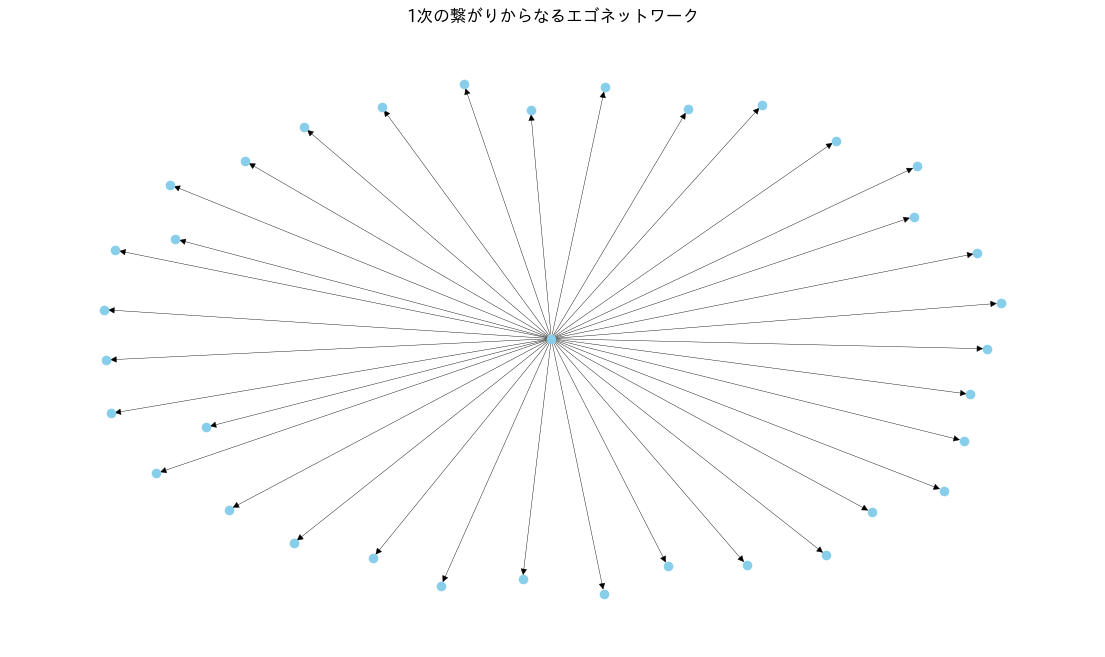

In [7]:
#random.seed(42)

id = "W2741809807"
center_node = Works()[id]


# center_node = Works().random()
# id = center_node["id"]
cited_node_ids = center_node["referenced_works"]

# 論文の引用文献一覧
one_hop_edge_list = [(center_node["id"], cited_node_id) for cited_node_id in cited_node_ids]

# グラフの作成
one_hop_graph = create_graph_from_edge_list(one_hop_edge_list)

# グラフの描画
display_graph(graph = one_hop_graph, title = "1次の繋がりからなるエゴネットワーク")

上の図は1次の繋がりからなるエゴネットワークです。全てのノードが中心のノードと繋がっているため、エゴネットワークではこのような放射状のグラフになります。  
続いて2次の繋がりを見ていきましょう。

In [8]:
# 1次のつながりのエッジ情報を記録
two_hop_edge_list = one_hop_edge_list.copy()
two_hop_node_ids = []

i = 0
for cited_node_id in tqdm(cited_node_ids):
    one_hop_node = Works()[cited_node_id]
    two_hop_node_ids += one_hop_node["referenced_works"]
    for two_hop_node_id in one_hop_node["referenced_works"]:
        two_hop_edge_list.append((cited_node_id, two_hop_node_id))
    time.sleep(0.1) #APIの呼び出し制限を回避する


# グラフの作成
two_hop_graph = create_graph_from_edge_list(two_hop_edge_list)
# グラフの描画
display_graph(graph = two_hop_graph, title = "2次の繋がりからなるエゴネットワーク")

  0%|          | 0/35 [00:00<?, ?it/s]

 11%|█▏        | 4/35 [00:08<01:02,  2.01s/it]


KeyboardInterrupt: 

上のグラフでは1次のつながりのノードが中心部に近いところに位置しており、2次のつながりのノードは周辺部に分散して存在するのがわかります。


### 共引用
上記までのネットワークでは論文同士を単純な引用関係で結んでいました。  
しかし実際のSciSciのネットワーク分析では共引用ネットワークの分析を行うことがほとんどです。  
共引用ネットワークでは、2つの論文が同じ論文によって引用されている場合にリンクで繋がれるネットワークです。  
まずは先ほどまでと同じエゴネットワークから見ていきましょう。

In [ ]:
# input：リスト
def combinations(lst):
    result = []
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            result.append((lst[i], lst[j]))
    return result


id = "W2741809807"
center_node = Works()[id]

# center_node = Works().random()
# id = center_node["id"]
cited_node_ids = center_node["referenced_works"]

# 共引用のリスト
one_hop_co_citation_edge_list = combinations(cited_node_ids)

# グラフの作成
one_hop_co_citation_graph = create_graph_from_edge_list(one_hop_co_citation_edge_list)

# グラフの描画
display_graph(graph = one_hop_co_citation_graph, title = "1次の繋がりからなる共引用ネットワーク")

NameError: name 'create_graph_from_edge_list' is not defined

上記のようにある1つの論文が引用している論文群は全て互いに共引用の関係にあるので、1次の引用関係のエゴネットワークは共引用ネットワークにおいて完全グラフ（すべてのノードの組み合わせにリンクが貼られるグラフ）になります。

## 特定のFieldから論文を抽出

OpenAlexにおいて、Topicは以下の画像のような関係になっています。  
ここでは特定のFieldから論文を1万件取得して、そこで共引用ネットワークを構築してみましょう。  
Field_idの対応はこちらのページから確認できます。
![OpenAlexにおけるTopic](https://2520693015-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2FpHVuV3Ib5KXeBKft4Kcl%2Fuploads%2Fgit-blob-a41f526188c79e0fc5e09e9fea3eb25a1e525b3e%2Ftopics_diag1.png?alt=media)

In [30]:
# 取得したいfield_idを指定
subfield_id = 1311 #
THRESHOLD = 2

pyalexObj = Works().filter(primary_topic={"subfield":{"id":subfield_id}}, cited_by_count=f">{THRESHOLD-1}").select(["id","referenced_works","primary_topic"])
field_count = pyalexObj.count()
field_works = util.getAll(pyalexObj.sample(5000, seed=42))

print(f"取得した論文数/分野内の論文数：{len(field_works)}/{field_count} ({round(len(field_works)/field_count*100,2)}%)" )

ConnectionError: HTTPSConnectionPool(host='api.openalex.org', port=443): Max retries exceeded with url: /works?filter=primary_topic.subfield.id:1311,cited_by_count:%3E1&select=id,referenced_works,primary_topic&per-page=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x149929d90>: Failed to establish a new connection: [Errno 51] Network is unreachable'))

In [ ]:
from collections import Counter
from itertools import combinations

def create_tuples(group):
    ids = group["id"].tolist()
    id_combinations = list(combinations(ids, 2))  # Generate all combinations of IDs
    return id_combinations

works = pd.DataFrame(field_works)
works = works.drop_duplicates(subset="id")
works["primary_topic"] = works["primary_topic"].apply(lambda x: x["id"].split("/")[-1].replace("T","")).astype(int)

result = works[["id","referenced_works"]].explode(column="referenced_works").groupby("referenced_works").apply(create_tuples).reset_index(name="id_tuples")
field_edge_list = pd.DataFrame(np.sum(result["id_tuples"].values))

tuple_array = [tuple(row) for _, row in field_edge_list.iterrows()]

tuple_counts = Counter(tuple_array)
filtered_tuples = [tpl for tpl, count in tuple_counts.items() if count >= THRESHOLD]

print(len(field_edge_list))
print(len(filtered_tuples))

47623
2950


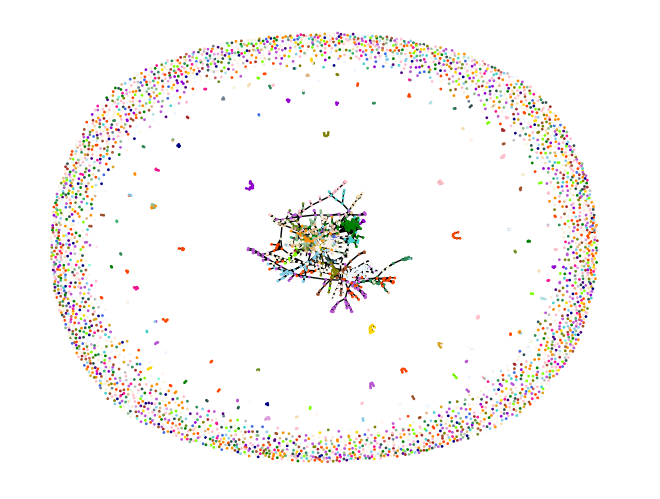

In [ ]:
import matplotlib.colors as mplc
# G の作成
G = nx.Graph()
G.add_nodes_from(works["id"])
G.add_edges_from(filtered_tuples)

# ノードの色を指定
unique_values = works["primary_topic"].unique()
num_unique = len(unique_values)
cmap = random.sample(list(mplc.CSS4_COLORS.values()),num_unique) 

color_dict = {value: cmap[i % num_unique] for i, value in enumerate(unique_values)}

# connected_components = list(nx.connected_components(G))
# most_connected_component = max(connected_components, key=len)
# subgraph = G.subgraph(most_connected_component)

colors = [color_dict[value] for value in works["primary_topic"]]

node_colors = colors

# グラフの描画
nx.draw(G, node_color=node_colors, node_size=1,with_labels=False)
plt.show()

In [ ]:
len(works["primary_topic"].unique()), len(pd.Series(colors).unique())

NameError: name 'works' is not defined

## クラスタリングの実施

ネットワークにはノードが密集しているようなコミュニティ構造が見られることが多々あります。このような構造を有効に検出するための手法としてクラスタリングが挙げられます。  
ネットワークにおけるクラスタリング手法は様々ありますが、多くの場合モジュラリティという指標を最適化することでコミュニティ構造を検出することが可能となります。  

$$
Q = \frac{1}{2m} \sum_{i,j} \left[A_{ij} - \frac{k_i k_j}{2m}\right] \delta(c_i, c_j)
$$

$Q$: モジュラリティ \\
$A_{ij}$: ノード$i$とノード$j$の接続関係を表す非負の値（0か1の二値で表現される） \\
$k_i$: ノード$i$の次数 \\
$c_i$: ノード $i$ が属するコミュニティ \\
$\delta(c_i, c_j)$: コミュニティ $c_i$ と $c_j$ が同じかどうかを示すδ関数（0か1の二値で表現される） \\
$m$: エッジの総数 \\

モジュラリティを最適化するアルゴリズムとして長らくLouvain法と呼ばれる手法を用いられてきましたが、近年ではその改良版であるleiden法を用いることが増えてきました。  
今回もleiden法を用いて共引用ネットワークのクラスタリングを行ってみましょう。



In [ ]:
import leidenalg

# leiden法はランダム性があるので一貫した結果を得るためにseedを固定する
SEED = 42
random.seed(SEED)

def leiden_clustering(graph):
    # Leidenクラスタリングを実行
    partition = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition)
    # クラスタリング結果をノード属性に追加
    for node, cluster_id in enumerate(partition):
        graph.nodes[node]['cluster'] = cluster_id
    return graph

springer_graph = leiden_clustering(G)

NameError: name 'springer_graph' is not defined

クラスタによってノードを色分けしたグラフは以下のようになります。

ネットワーク上でクラスタリング

## Archive（使わないやつ）

### 外向きの引用ネットワーク

上までは中心ノードが引用していた論文に注目してネットワークを構築しましたが、今度は「中心ノードが引用されている論文」に注目してネットワークを構築してみましょう。先ほどのネットワークとはリンクの向きが逆になるはずです。
※先ほどは

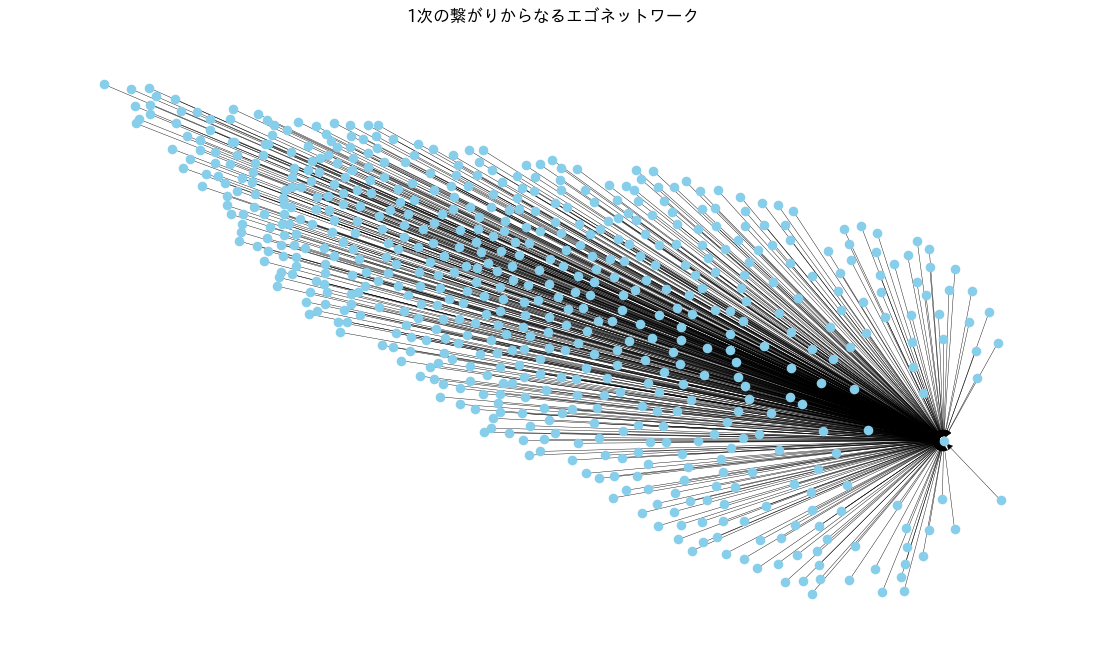

In [ ]:
#random.seed(42)

id = "W2741809807"
center_node = Works()[id]
one_hop_nodes = get_cited_works(id)

# 論文の引用文献一覧
one_hop_edge_list = [(one_hop_node["id"], center_node["id"]) for one_hop_node in one_hop_nodes]

# グラフの作成
one_hop_graph = create_graph_from_edge_list(one_hop_edge_list)

# グラフの描画
display_graph(graph = one_hop_graph, title = "1次の繋がりからなるエゴネットワーク")

100%|██████████| 614/614 [04:44<00:00,  2.16it/s]


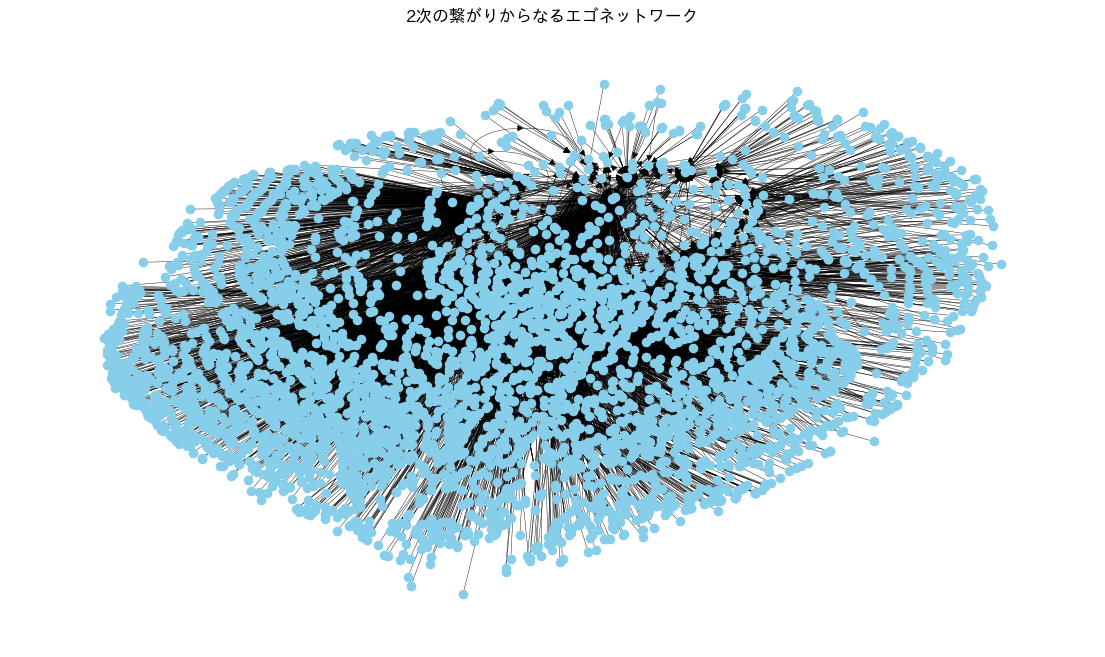

In [ ]:
# 1次のつながりのエッジ情報を記録
two_hop_edge_list = one_hop_edge_list.copy()
two_hop_nodes = []

i = 0
for one_hop_node in tqdm(one_hop_nodes):
    two_hop_node_list = get_cited_works(one_hop_node["id"])
    two_hop_nodes += two_hop_node_list
    for two_hop_node in two_hop_node_list:
        two_hop_edge_list.append((two_hop_node["id"], one_hop_node["id"]))


# グラフの作成
two_hop_graph = create_graph_from_edge_list(two_hop_edge_list)
# グラフの描画
display_graph(graph = two_hop_graph, title = "2次の繋がりからなるエゴネットワーク")

# ネットワーク作成に7分、描画に1分30秒

### 1つの論文誌に注目したネットワーク

次に1つの論文誌に着目してネットワークを構築してみましょう。  

In [ ]:
source = Sources().filter(works_count=">1000000").get()[:10]
pd.DataFrame(map(lambda x: [x["id"],x["display_name"], x["host_organization_name"], x["is_oa"],x["works_count"]],source),
            columns=["id","論文誌名","論文誌発行機関","OA誌かどうか", "累計論文発行数"])

,id,論文誌名,論文誌発行機関,OA誌かどうか,累計論文発行数
0,https://openalex.org/S4306525036,PubMed,National Institutes of Health,False,33075864
1,https://openalex.org/S2764455111,PubMed Central,National Institutes of Health,True,8009760
2,https://openalex.org/S4306400806,Europe PMC (PubMed Central),European Bioinformatics Institute,True,5316266
3,https://openalex.org/S4306400194,arXiv (Cornell University),Cornell University,True,3015170
4,https://openalex.org/S4306401280,DOAJ (DOAJ: Directory of Open Access Journals),None,True,2672478
5,https://openalex.org/S4306402512,HAL (Le Centre pour la Communication Scientifi...,French National Centre for Scientific Research,True,2571027
6,https://openalex.org/S4306463937,Springer eBooks,Springer Nature,False,2519831
7,https://openalex.org/S4306400562,Zenodo (CERN European Organization for Nuclear...,European Organization for Nuclear Research,True,1405433
8,https://openalex.org/S4306401271,RePEc: Research Papers in Economics,Federal Reserve Bank of St. Louis,True,1126422
9,https://openalex.org/S4210172589,Social Science Research Network,RELX Group (Netherlands),False,1079692


今回はSpringer eBooksの論文でネットワークを構築してみましょう。  
論文を取得する際に、論文誌のidが必要になるので上で判明したものを使います。

In [ ]:
def get_works_in_source(source_id):
    pager = Works().filter(locations={"source":{"id":source_id}}).paginate(per_page=200, n_max=1000)
    works = []
    for page in tqdm(pager):
        if len(page)>0:
            works += page
    return works

source_id = "https://openalex.org/S4306463937"

start_time = time.time()
springer_works = get_works_in_source(source_id)
end_time = time.time()
print(f"処理時間：{end_time - start_time}")

5it [00:05,  1.08s/it]

処理時間：5.413801193237305


ここではSpringer eBooks内の論文を1000本サンプリングしたので、このノードを用いて共引用ネットワークを構築します。  

In [ ]:
def make_co_citation_graph_from_ids(id_list):
    entire_edge_list = []
    for id in tqdm(id_list):
        target_work = Works()[id]
        cited_work_ids = target_work["referenced_works"]
        edge_list = combinations(cited_work_ids)
        entire_edge_list += edge_list
    co_citation_graph = create_graph_from_edge_list(entire_edge_list, directed = False)
    return co_citation_graph

In [ ]:
target_work_ids = [work["id"] for work in springer_works]
target_edge_list = []

springer_co_citation_graph = make_co_citation_graph_from_ids(target_work_ids)

100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


In [ ]:
# グラフの描画
start_time = time.time()
display_graph(graph = springer_co_citation_graph, title = "Springer eBooksからなる共引用ネットワーク")
end_time = time.time()

print(f"処理時間：{end_time - start_time}")

上記の結果を見ますと、引用関係が密に繋がっている部分と疎に繋がっている部分に分けられることがわかります。  

ネットワークにおいてノードが密に繋がっている構造はコミュニティ構造と呼ばれ、ネットワークの性質を分析するにあたって非常に重要なものになります。

次の章ではこのコミュニティ構造が何を表しているのかを深掘りするために、クラスタリングを実施します。

### 特定のKWに絞って論文を抽出

上記では特定のFieldに絞って論文群を抽出しましたが、特定のキーワードを元にして作ることもできます。

In [ ]:
def get_works_in_field(field):
    pager = Works().filter(keywords={"keyword":field}).paginate(per_page=200, n_max=100000)
    works = []
    for page in tqdm(pager):
        if len(page)>0:
            works += page
    return works

keyword = "Machine Learning"#kinesin

start_time = time.time()
keyword_works = get_works_in_field(keyword)
end_time = time.time()
print(f"処理時間：{end_time - start_time}")

6it [00:05,  1.01it/s]

処理時間：5.968630790710449


In [ ]:
len(keyword_works)

927

Topicsレベルで色分けを行なって見れば細かい粒度で見られるね。

In [ ]:
# 1hopまでのグラフ
field_work_ids = set([field_work["id"] for field_work in field_works])
field_edge_list = []

# TODO 最低引用数が5以上でフィルタリング
for field_work in tqdm(field_works):
    id = field_work["id"]
    referenced_works = field_work["referenced_works"]
    filtered_node_list = []
    for node_id in referenced_works:
        if node_id in field_work_ids:
            filtered_node_list.append(node_id)

    edge_list = combination(filtered_node_list)
    field_edge_list += edge_list

# グラフの作成
field_co_citation_graph = make_co_citation_graph_from_ids(field_edge_list)


# グラフの描画
start_time = time.time()
display_graph(graph = field_co_citation_graph, title = "特定分野の共引用ネットワーク")
end_time = time.time()

print(f"処理時間：{end_time - start_time}")

  1%|          | 2/200 [03:23<5:35:17, 101.60s/it]


KeyboardInterrupt: 